In [72]:
import scanpy as sc
import os
import anndata
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE
import umap
import ipywidgets as widgets
from IPython.display import display
from scanpy.metrics.specificity.plot import marker_genes_distribution, one_v_max_genelist


In [73]:
DATA_PATH = r'data/'

In [74]:
spec_file = 'spec_summary.tsv'
speci_summary = pd.read_csv(DATA_PATH + spec_file, sep='\t',index_col='gene').iloc[:,1:]
speci_summary = speci_summary[speci_summary['one_v_max']<50]
specificities = speci_summary.iloc[:,2:-1]
labels = speci_summary.iloc[:,-1]


In [75]:
count_file = 'HCA_Barbry_Grch38_Raw_filter_Norm.h5ad'
adata = anndata.read_h5ad(DATA_PATH + count_file)

C:\Users\ipmc\.conda\envs\scanpypip\lib\site-packages\anndata\compat\__init__.py:158: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
C:\Users\ipmc\.conda\envs\scanpypip\lib\site-packages\anndata\compat\__init__.py:158: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


Filtering

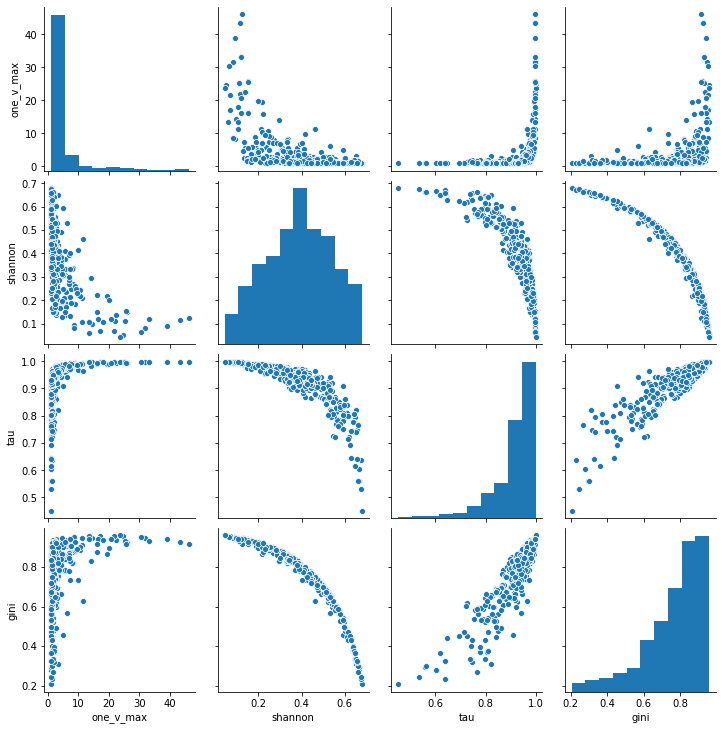

In [5]:
sns.pairplot(specificities)

On va filtrer les one_v_max trop élevés, disons d'abord à 250
On normalize une première fois de façon un peu wild les one_v_max

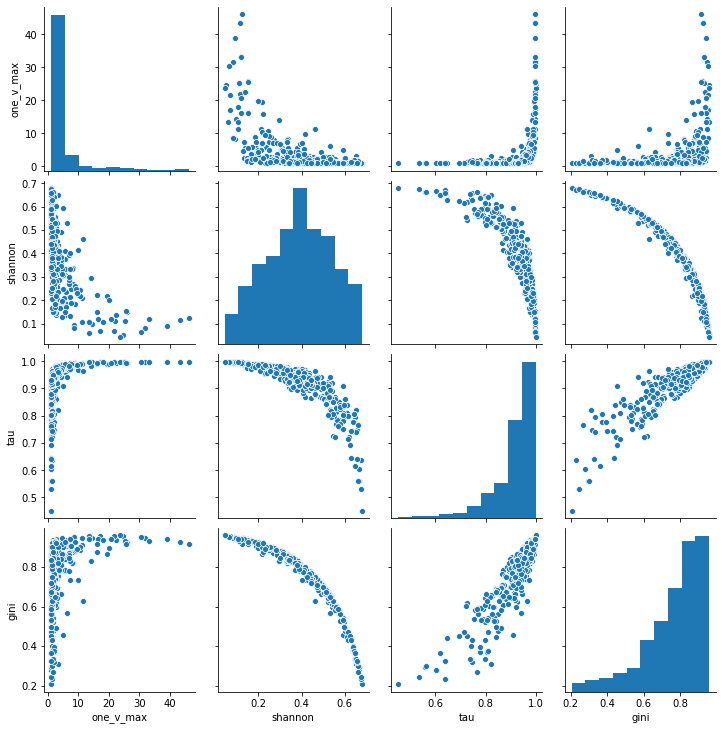

In [6]:
specificities = specificities[specificities['one_v_max']<50]
specificities['one_v_max'].div(max(specificities.loc[:,'one_v_max']))
sns.pairplot(specificities)

In [7]:
specificities

,one_v_max,shannon,tau,gini
gene,,,,
HIGD1B,43.428460,0.116332,0.996071,0.926239
GJC1,2.595128,0.520527,0.924579,0.623920
NOTCH3,5.420388,0.411299,0.959513,0.781575
RGS5,3.494081,0.191721,0.986012,0.912158
CDH6,1.951093,0.202773,0.976499,0.923820
...,...,...,...,...
C9orf116,1.188363,0.424885,0.914925,0.751722
DNAAF1,1.241585,0.388257,0.932861,0.792629
CCDC170,1.190883,0.380209,0.928739,0.812769


PCA

In [42]:
pca = PCA(n_components=2)

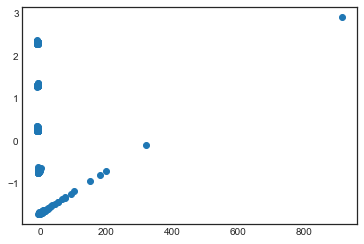

In [43]:
pca.fit(specificities)
X=pca.transform(specificities)
plt.scatter(X[:,0],X[:,1])

Pas super concluant...

La même chose sur toutes les cellules

In [79]:
spec_full = 'spec_full.csv'
speci_full = pd.read_csv(DATA_PATH + spec_full, sep=',',index_col='gene')
speci_full

,one_v_max,shannon,tau,gini
gene,,,,
AL669831.5,1.561921,0.637306,0.742319,0.391246
LINC00115,1.226817,0.628045,0.626468,0.399453
FAM41C,1.125282,0.637185,0.663437,0.393725
NOC2L,1.463043,0.673486,0.569871,0.219136
PLEKHN1,1.832154,0.519458,0.867355,0.665310
...,...,...,...,...
AC007325.4,3.163253,0.538201,0.907686,0.615957
AC007325.2,1.077784,0.414222,0.886558,0.792062
AL354822.1,1.268024,0.604515,0.729433,0.467284


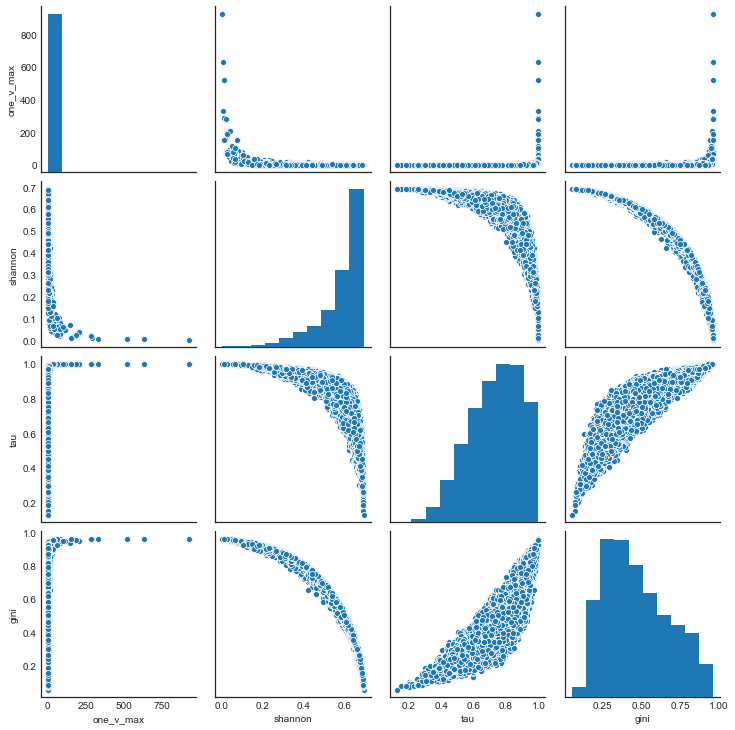

In [45]:
sns.pairplot(speci_full)

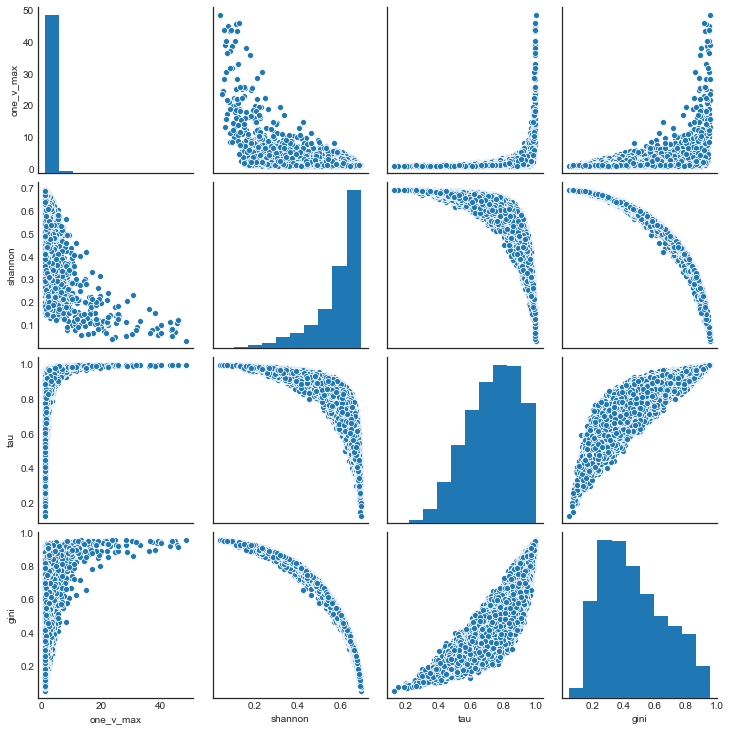

In [46]:
speci_full = speci_full[speci_full['one_v_max']<50]
speci_full['one_v_max'].div(max(speci_full.loc[:,'one_v_max']))
sns.pairplot(speci_full)

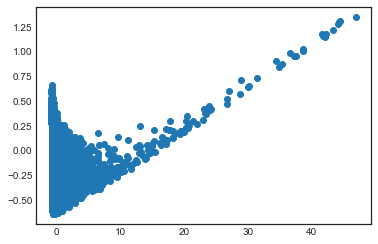

In [47]:
pca.fit(speci_full)
X=pca.transform(speci_full)
plt.scatter(X[:,0],X[:,1])

tSNE repr full

In [48]:
tsne = TSNE(n_components=2)
X = tsne.fit_transform(X)


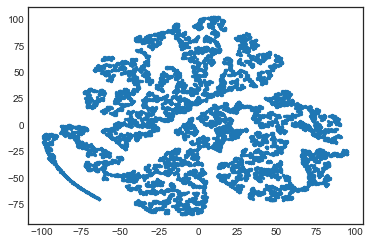

In [49]:
plt.scatter(X[:,0],X[:,1],s = 5)

Umap repr smol

In [50]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(specificities)
embedding.shape

(366, 2)

In [51]:
embedding = pd.DataFrame(embedding, index=labels.index,columns=['UMAP1','UMAP2'])
embedding['labels'] = labels
embedding

ValueError: Shape of passed values is (366, 2), indices imply (353, 2)

In [ ]:
sns.lmplot('UMAP1', 'UMAP2', data=embedding, hue='labels', fit_reg=False)

Umap repr full

In [ ]:
reducer = umap.UMAP()
embedding_full = reducer.fit_transform(speci_full)
embedding_full.shape

In [ ]:
plt.scatter(embedding_full[:,0],embedding_full[:,1])

Grouping specificity types

Kmeans

In [ ]:
from sklearn.cluster import KMeans
kmean = KMeans(n_clusters=4, random_state=0)
clusters_kmeans=kmean.fit(embedding)

In [ ]:
sns.scatterplot(embedding[:,0],embedding[:,1], hue=clusters_kmeans.labels_).set_title('kmeans_clusters')
plt.show()

In [ ]:
specificities['kmeans_clusters']=clusters_kmeans.labels_
specificities.groupby('kmeans_clusters').describe()

With DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=1)
clusters_db=dbscan.fit(embedding)

In [ ]:
sns.scatterplot(embedding[:,0],embedding[:,1], hue=clusters_db.labels_).set_title('db_clusters')
plt.show()

In [ ]:
specificities['db_clusters']=clusters_db.labels_
specificities.groupby('db_clusters').describe()

Full with kmeans

In [ ]:
kmean = KMeans(n_clusters=4, random_state=0)
clusters_kmeans_full=kmean.fit(embedding_full)

In [ ]:
sns.scatterplot(embedding_full[:,0],embedding_full[:,1], hue=clusters_kmeans_full.labels_).set_title('db_clusters')
plt.show()

Regardons à l'oeil si nos spécificités veulent dire qq chose

In [ ]:
group0 = specificities.loc[specificities['db_clusters'] == 0]
group0 = group0.iloc[np.random.randint(0,(specificities['db_clusters'] == 0).sum(),16)]
group1 = specificities.loc[specificities['db_clusters'] == 1]
group1 = group1.iloc[np.random.randint(0,(specificities['db_clusters'] == 1).sum(),16)]
group2 = specificities.loc[specificities['db_clusters'] == 2]
group2 = group2.iloc[np.random.randint(0,(specificities['db_clusters'] == 2).sum(),16)]
group3 = specificities.loc[specificities['db_clusters'] == 3]
group3 = group3.iloc[np.random.randint(0,(specificities['db_clusters'] == 3).sum(),16)]

In [ ]:
from scanpy.metrics.specificity.plot import marker_genes_distribution, one_v_max_genelist

marker_genes_distribution(adata=adata,
                          gene_list=group0.index,
                          celltype=None,
                          partition_key='CellType')
sc.pl.umap(adata=adata, color=group0.index, color_map = 'jet')

In [ ]:
marker_genes_distribution(adata=adata,
                          gene_list=group1.index,
                          celltype=None,
                          partition_key='CellType')
sc.pl.umap(adata=adata, color=group0.index, color_map = 'jet')

In [ ]:
marker_genes_distribution(adata=adata,
                          gene_list=group2.index,
                          celltype=None,
                          partition_key='CellType')
sc.pl.umap(adata=adata, color=group0.index, color_map = 'jet')

In [ ]:
marker_genes_distribution(adata=adata,
                          gene_list=group3.index,
                          celltype=None,
                          partition_key='CellType')
sc.pl.umap(adata=adata, color=group0.index, color_map = 'jet')

In [ ]:
group0 = specificities.loc[specificities['db_clusters'] == 0]
group0 = group0.iloc[np.random.randint(0,(specificities['db_clusters'] == 0).sum(),16)]

In [ ]:
group0

On entraine un tree classifier sur des gènes annotés à la main

In [76]:
spec_file = 'spec_summary.tsv'
speci_summary = pd.read_csv(DATA_PATH + spec_file, sep='\t',index_col='gene').iloc[:,1:]
specificities = speci_summary.iloc[:,2:]

In [59]:
X = specificities.iloc[:,0:-1]
y = specificities.iloc[:,-1]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [60]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

In [61]:
clf = DecisionTreeClassifier(random_state=0, 
                             max_depth=4)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=0)

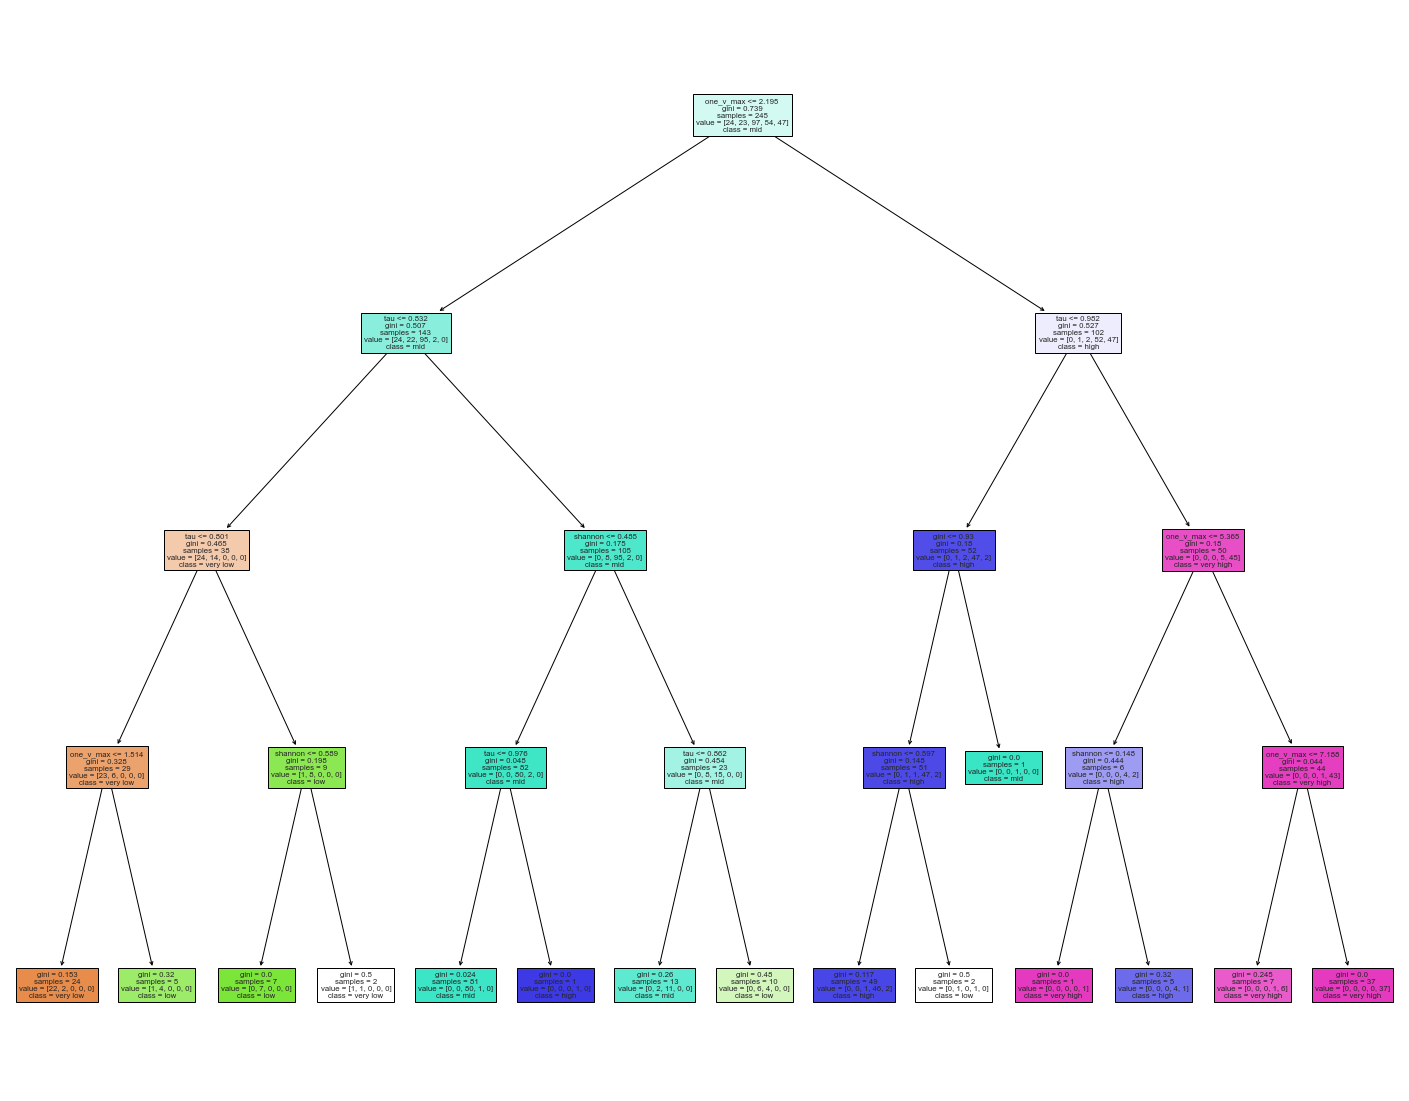

In [62]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf,
                   feature_names=['one_v_max', 'shannon', 'tau', 'gini'],  
                   class_names=['very low','low','mid','high','very high'],
                   filled=True)

In [63]:
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import accuracy_score,confusion_matrix
depth=4
clf = DecisionTreeClassifier(random_state=0, 
                             max_depth=depth)

In [64]:
cv_score = cross_validate(clf,X,y,cv=10)

In [65]:
cv_score

{'fit_time': array([0.00498605, 0.00299144, 0.00299096, 0.00299191, 0.00299239,
        0.00199485, 0.00299215, 0.00299358, 0.00398827, 0.00199246]),
 'score_time': array([0.00199533, 0.00199509, 0.00199437, 0.00099754, 0.00099754,
        0.00099707, 0.00099707, 0.00099754, 0.00102973, 0.00099754]),
 'test_score': array([0.83783784, 0.94594595, 0.89189189, 0.81081081, 0.75675676,
        0.81081081, 0.86111111, 0.80555556, 0.80555556, 0.94444444])}

La loose, mon annotation n'a aucun sens...

In [66]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100,
                             max_depth=4)

In [67]:
cv_score = cross_validate(rfc,X,y,cv=5)

In [68]:
cv_score['test_score']

array([0.89189189, 0.90410959, 0.8630137 , 0.82191781, 0.8630137 ])

Essayons de prédire des trucs

In [69]:
cv_pred = cross_val_predict(rfc,X,y,cv=5)

In [70]:
accuracy_score(y,cv_pred)

0.8633879781420765

(array([ 35.,  19., 167.,  81.,  64.]),
 array([0, 1, 2, 3, 4, 5]),
 <BarContainer object of 5 artists>)

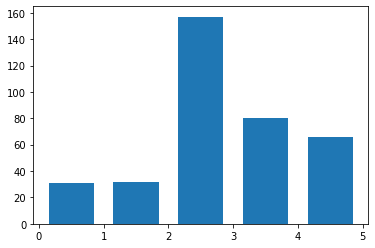

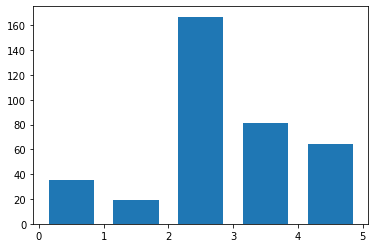

In [20]:
plt.hist(y,bins=[0,1,2,3,4,5],rwidth=0.7)
plt.figure()
plt.hist(cv_pred,bins=[0,1,2,3,4,5],rwidth=0.7)

<AxesSubplot:>

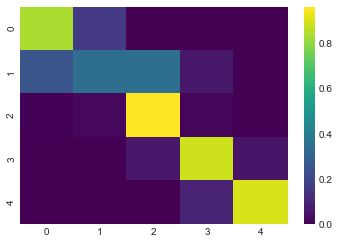

In [32]:
cm=confusion_matrix(y,cv_pred)
cm_norm=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, cmap="viridis")

Visualisation des groupes

In [33]:
spec_full = pd.DataFrame(X)
spec_dict={'0':'equirep','1':'low','2':'multi-spec','3':'high','4':'unique'}
spec_full['spec_hand'] = y.apply(str).replace(spec_dict)
spec_full['cv_rfc_pred'] = pd.Series(cv_pred,index=spec_full.index).apply(str).replace(spec_dict)


In [34]:
dropdown_pred = widgets.Dropdown(options=['spec_hand','cv_rfc_pred'],
                                 value='spec_hand',    
                                 description='Choose the specificity prediction',
                                 disabled=False,
                                )

dropdown_spec_type = widgets.Dropdown(options=['equirep','low','multi-spec','high','unique'],
                                      value='unique',
                                      description='Choose the specificity type',
                                      disabled=False,
                                     )


In [35]:
output_marker = widgets.Output()

def format_title(gene):
    return f'{str(gene)}. Hand:' + str(spec_full.loc[gene,'spec_hand']) + '. rfc:' + spec_full.loc[gene,'cv_rfc_pred']

def common_plot(pred_type, spec):
    output_marker.clear_output()
    with output_marker :
        gene_group = spec_full[spec_full[pred_type] == spec]
        gene_group = gene_group.iloc[np.random.randint(0,(spec_full[pred_type] == spec).sum(),16)]
        print(f'You are displaying the {spec} specificity genes from the {pred_type} annotation. ')
        marker_genes_distribution(adata=adata,
                                  gene_list=gene_group.index,                                  
                                  celltype=None,
                                  partition_key='CellType')
        sc.pl.umap(adata=adata, color=gene_group.index, color_map = 'jet', title=pd.Series(gene_group.index).apply(format_title))

In [36]:
def dropdown_pred_eventhandler(change):
    common_plot(change.new,dropdown_spec_type.value)
    
def dropdown_spec_type_eventhandler(change):
    common_plot(dropdown_pred.value,change.new)
        
        
dropdown_pred.observe(dropdown_pred_eventhandler,names='value')
dropdown_spec_type.observe(dropdown_spec_type_eventhandler,names='value')


In [37]:
display(dropdown_pred)
display(dropdown_spec_type)

Dropdown(description='Choose the specificity prediction', options=('spec_hand', 'cv_rfc_pred'), value='spec_ha…

Dropdown(description='Choose the specificity type', index=4, options=('equirep', 'low', 'multi-spec', 'high', …

In [ ]:
display(output_marker)

In [39]:
def get_mismatch_genes(y_true,y_pred):
    return spec_full[spec_full[y_true] != spec_full[y_pred]].index

In [40]:
mismatches = np.array(get_mismatch_genes('spec_hand','cv_rfc_pred'))
mismatches

array(['NOTCH3', 'RGS5', 'CDH6', 'SRGN', 'RGS2', 'RALGPS2', 'NUSAP1',
       'SMC4', 'DCN', 'COL1A1', 'FBLN2', 'NEXN', 'S100A1', 'PRB1',
       'PHLDA1', 'CRISP3', 'MT1X', 'FAM3B', 'SUSD4', 'FAM84A', 'CCDC14',
       'AGR2', 'FGGY', 'SLC26A2', 'ITLN1', 'GLYATL2', 'BPIFB1', 'LGALS2',
       'CFP', 'CSTA', 'AKR1C1', 'LYNX1', 'MPV17L', 'MUC16', 'PI3',
       'S100P', 'VSIG2', 'SCGB3A1', 'SCGB1A1', 'SEC11C', 'SSR4', 'BCAM',
       'SMC2', 'DST', 'EMP3', 'SPRY1', 'IFITM1'], dtype=object)

In [ ]:
marker_genes_distribution(adata=adata,
                                  gene_list=mismatches,                                  
                                  celltype=None,
                                  partition_key='CellType')


In [ ]:
sc.pl.umap(adata=adata, color=mismatches, color_map = 'jet', title=pd.Series(mismatches).apply(format_title))

Full Prediction

In [184]:
X_train = specificities.iloc[:,0:-1]
y_train = specificities.iloc[:,-1]
X_pred = speci_full.loc[~X_pred.index.isin(X_train.index)]

IndexError: Boolean index has wrong length: 13983 instead of 14349

In [190]:
rfc = RandomForestClassifier(n_estimators=100,
                             max_depth=4)
rfc.fit(X_train,y_train)

RandomForestClassifier(max_depth=4)

In [191]:
y_pred = rfc.predict(X_pred)

(array([8595.,    0., 1364.,    0.,    0., 2648.,    0., 1216.,    0.,
         160.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

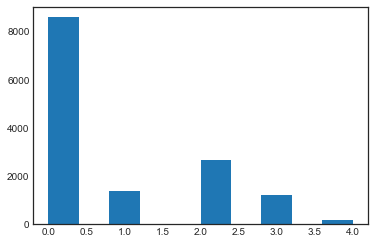

In [192]:
plt.hist(y_pred)

In [193]:
X_train

,one_v_max,shannon,tau,gini
gene,,,,
HIGD1B,43.428460,0.116332,0.996071,0.926239
GJC1,2.595128,0.520527,0.924579,0.623920
NOTCH3,5.420388,0.411299,0.959513,0.781575
RGS5,3.494081,0.191721,0.986012,0.912158
CDH6,1.951093,0.202773,0.976499,0.923820
...,...,...,...,...
C9orf116,1.188363,0.424885,0.914925,0.751722
DNAAF1,1.241585,0.388257,0.932861,0.792629
CCDC170,1.190883,0.380209,0.928739,0.812769


In [194]:
spec_w_pred = pd.concat([X_train,X_pred])
y_tot = pd.concat([y_train,pd.Series(y_pred,index = X_pred.index)])

In [195]:
spec_dict={'0':'equirep','1':'low','2':'multi-spec','3':'high','4':'unique'}
spec_w_pred['spec_type'] = y_tot.apply(str).replace(spec_dict)

In [196]:
spec_w_pred.to_csv(DATA_PATH + 'genes_spec_pred_V1')

In [197]:
spec_w_pred

,one_v_max,shannon,tau,gini,spec_type
gene,,,,,
HIGD1B,43.428460,0.116332,0.996071,0.926239,unique
GJC1,2.595128,0.520527,0.924579,0.623920,high
NOTCH3,5.420388,0.411299,0.959513,0.781575,unique
RGS5,3.494081,0.191721,0.986012,0.912158,unique
CDH6,1.951093,0.202773,0.976499,0.923820,high
...,...,...,...,...,...
AC007325.4,3.163253,0.538201,0.907686,0.615957,high
AC007325.2,1.077784,0.414222,0.886558,0.792062,multi-spec
AL354822.1,1.268024,0.604515,0.729433,0.467284,equirep


In [198]:
X_pred

,one_v_max,shannon,tau,gini
gene,,,,
AL669831.5,1.561921,0.637306,0.742319,0.391246
LINC00115,1.226817,0.628045,0.626468,0.399453
FAM41C,1.125282,0.637185,0.663437,0.393725
NOC2L,1.463043,0.673486,0.569871,0.219136
PLEKHN1,1.832154,0.519458,0.867355,0.665310
...,...,...,...,...
AC007325.4,3.163253,0.538201,0.907686,0.615957
AC007325.2,1.077784,0.414222,0.886558,0.792062
AL354822.1,1.268024,0.604515,0.729433,0.467284
